In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPU 2 to use
import threestudio

import math
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

import kiui

from threestudio.models.materials.pbr_material import PBRMaterial
from threestudio.models.geometry.custom_mesh import CustomMesh

In [2]:
# prompt = "A sleek, 3D-rendered teddy bear characterized by smooth, rounded features, a large spherical head, small round ears, short limbs with cylindrical legs and arms, and a stout, rotund body. The bear exhibits a simplistic and minimalist design with subtle details on its face and limbs"
# prompt = "an albedo map of a high quality 3D model of a helmet"
prompt = "an albedo map of high quality 3D model of a helmet. colormap, muted realistic colors"
negative_prompt = "oversaturated color, ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, poorly drawn eyes, low contrast, underexposed, overexposed, bright blue spots, glowing blue patches, intense blue highlights, Unrealistic highlights, Artificial shininess, Exaggerated light reflections, Unnatural facial expression, Inauthentic eye contact, low resolution"
# prompt = "a photo of a backpack"
# negative_prompt = "text, watermark, lowres, low quality, worst quality, deformed, glitch, low contrast, noisy, saturation, blurry"
# negative_prompt = "oversaturated color, ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, poorly drawn eyes, low contrast, underexposed, overexposed, bright blue spots, glowing blue patches, intense blue highlights, Unrealistic highlights, Artificial shininess, Exaggerated light reflections, Unnatural facial expression, Inauthentic eye contact, low resolution"
# negative_prompt = "flat texture, unrealistic fur patterns, unnatural shading, disjointed symmetry, artificial depth"
# negative_prompt = "The areas around the eyes, nose, and mouth lack consistent alignment and proportionality, creating an irregular appearance from different angles."
# negative_prompt = "A uniquely colorful teapot adorned with vibrant fruit illustrations, sitting on a cozy living room table."
# prompt = "The 3D object is a stylized, armored creature or character with a bulky, segmented structure. It features prominent, curved, horn-like appendages on its head, round protrusions resembling rivets or spikes on its armor, and a robust, muscular design with articulated limbs."
# prompt = "A pumpkin-like object with a short, curved stem. The surface appears smooth but includes subtle vertical grooves, and one side features exaggerated, hollow eye sockets, giving it a menacing appearance"
# negative_prompt = ""
# tgt_prompt = "The image shows a teddy bear dressed in a formal white shirt, black tie, and black shorts."
tgt_prompt = ""

In [3]:
config = {
    'material_activation': 'sigmoid',
    'environment_texture': "load/lights/mud_road_puresky_1k.hdr",
    'environment_scale': 2.0,
    'min_metallic': 0.0,
    'max_metallic': 0.9,
    'min_roughness': 0.08,
    'max_roughness': 0.9,
    'use_bump': False
}

In [4]:
material = PBRMaterial(config)

/home/user/anaconda3/envs/threestudio/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Using /home/user/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/user/.cache/torch_extensions/py310_cu118/renderutils_plugin/build.ninja...
Building extension module renderutils_plugin...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module renderutils_plugin...


ninja: no work to do.


In [5]:
config_mesh = {
    'shape_init': "mesh:./load/shapes/helmet/helmet.obj",
    'shape_init_params': 1.0,
    'radius': 1.0, # consistent with coarse
    'pos_encoding_config': {
        'otype': 'HashGrid',
        'n_levels': 16,
        'n_features_per_level': 2,
        'log2_hashmap_size': 19,
        'base_resolution': 16,
        'per_level_scale': 1.4472692374403782 # max resolution 4096
    },
    'shape_init_mesh_up': '+y',
    'shape_init_mesh_front': '+z',
    'n_feature_dims': 8 # albedo3 + roughness1 + metallic1 + bump3
}

In [6]:
mesh = CustomMesh(config_mesh)
mesh

cuda:0


CustomMesh(
  (encoding): CompositeEncoding(
    (encoding): TCNNEncoding(
      (encoding): Encoding(n_input_dims=3, n_output_dims=32, seed=1337, dtype=torch.float32, hyperparams={'base_resolution': 16, 'hash': 'CoherentPrime', 'interpolation': 'Linear', 'log2_hashmap_size': 19, 'n_features_per_level': 2, 'n_levels': 16, 'otype': 'Grid', 'per_level_scale': 1.4472692012786865, 'type': 'Hash'})
    )
  )
  (feature_network): VanillaMLP(
    (layers): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=8, bias=False)
    )
  )
)

In [7]:
from threestudio.utils.rasterize import NVDiffRasterizerContext

In [8]:
rasterizer = NVDiffRasterizerContext("cuda", "cuda")

In [9]:
from threestudio.data.uncond import RandomCameraDataModuleConfig, RandomCameraDataset, RandomCameraIterableDataset, RandomCameraDataModule

In [10]:
camera_config = {
  'height': 512,
  'batch_size': 1,
  'width': 512,
  'camera_distance_range': [4, 4],
  'fovy_range': [25, 45],
  'camera_perturb': 0.,
  'center_perturb': 0.,
  'up_perturb': 0.,
  'elevation_range': [-20, 45],
  'azimuth_range': [-180, 180],
  'batch_uniform_azimuth': True,
  'eval_camera_distance': 4.,
  'eval_fovy_deg': 45.,
}

In [11]:
camera_module_config = RandomCameraDataModuleConfig(**camera_config)
dataset = RandomCameraIterableDataset(camera_module_config)

In [12]:
sample_data = dataset.collate(1)

In [13]:
sample_data.keys()

dict_keys(['rays_o', 'rays_d', 'mvp_mtx', 'camera_positions', 'c2w', 'light_positions', 'elevation', 'azimuth', 'camera_distances', 'height', 'width', 'fovy', 'proj_mtx'])

In [14]:
from threestudio.models.background.solid_color_background import SolidColorBackground

In [15]:
background_config = {
}

In [16]:
background = SolidColorBackground(background_config)

In [17]:
from threestudio.models.renderers.nvdiff_rasterizer import NVDiffRasterizer

In [18]:
rasterizer_config = {
    'context_type': "cuda",
}

In [19]:
mesh = mesh.to("cuda")
material = material.to("cuda")
background = background.to("cuda")

In [20]:
material

PBRMaterial(
  (light): EnvLight()
)

In [21]:
rasterizer = NVDiffRasterizer(rasterizer_config, mesh, material, background)

In [22]:
sample_data = dataset.collate(4)
sample_data.keys()

dict_keys(['rays_o', 'rays_d', 'mvp_mtx', 'camera_positions', 'c2w', 'light_positions', 'elevation', 'azimuth', 'camera_distances', 'height', 'width', 'fovy', 'proj_mtx'])

In [23]:
sample_data['azimuth']

tensor([-55.6467])

In [24]:
sample_data['camera_positions'][0]

tensor([ 2.2557, -3.3001, -0.1468])

tensor([-45.4100])


Tensor image torch.Size([1024, 1024, 3]) torch.float32 cuda:0 ∈ [0.21321293711662292, 1.0]

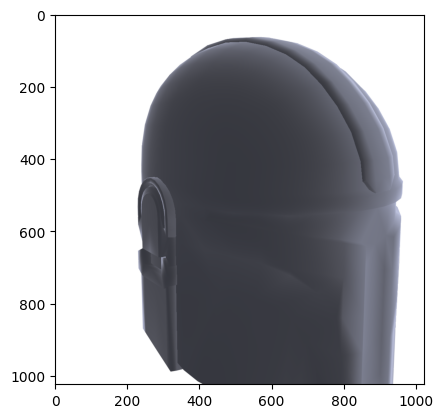

In [25]:
sample_data = dataset.collate(4)
i = 0
out = rasterizer(sample_data['mvp_mtx'][i:i+1].cuda(), sample_data['camera_positions'][i:i+1].cuda(), sample_data['light_positions'][i:i+1].cuda(), 1024, 1024, sample_data['c2w'][i:i+1].cuda())
print(sample_data['azimuth'])
kiui.vis.plot_image(out['comp_rgb'].reshape(1, 1024, 1024, 3))

In [40]:
diffusion_config = {
    'max_iters': 3000,
    'seed': 0,
    'scheduler': 'cosine',
    'mode': 'latent',
    'prompt_processor_type': 'stable-diffusion-prompt-processor',
    'prompt_processor': {
        'pretrained_model_name_or_path': 'runwayml/stable-diffusion-v1-5',
        'prompt': prompt,
        'negative_prompt': negative_prompt,
        'use_perp_neg': False
    },
    'guidance_type': 'stable-diffusion-ip-guidance',
    'guidance': {
        'half_precision_weights': True,
        'pretrained_model_name_or_path': 'runwayml/stable-diffusion-v1-5',
        'guidance_scale': 7.5,
        'weighting_strategy': 'fantasia3d',
        'min_step_percent': 0.02,
        'max_step_percent': 0.98,
        'grad_clip': None,
        'view_dependent_prompting': True,
        'use_plus': True,
        # 'scale': 0.5,
        # 'seed': 0,
        'image_path': './images/teapot_rembg.png',
        'xs_delta_t': 200,
        'xs_inv_steps': 5,
        'xs_eta': 0,
        'delta_t': 50,
        'delta_t_start': 100,
        'annealing_intervals': True,
        'use_img_loss': False,
    },
    'image': {
        'width': 1024,
        'height': 1024,
    }
}

In [41]:
guidance = None
prompt_processor = None

with torch.no_grad():
    torch.cuda.empty_cache()

guidance = threestudio.find(diffusion_config['guidance_type'])(diffusion_config['guidance'])
prompt_processor = threestudio.find(diffusion_config['prompt_processor_type'])(diffusion_config['prompt_processor'])
prompt_processor.configure_text_encoder()

Loading Stable Diffusion ...


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loaded Stable Diffusion!
Loaded Plus model!
Loaded IP-Adapter!
Using prompt [an albedo map of high quality 3D model of a helmet. colormap, muted realistic colors] and negative prompt [oversaturated color, ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, poorly drawn eyes, low contrast, underexposed, overexposed, bright blue spots, glowing blue patches, intense blue highlights, Unrealistic highlights, Artificial shininess, Exaggerated light reflections, Unnatural facial expression, Inauthentic eye contact, low resolution]
Using view-dependent prompts [side]:[an albedo map of high quality 3D model of a helmet. colormap, muted realistic colors, side view] [front]:[an albedo map of high quality 3D model of a helmet. colormap, muted realistic colors, front view] [back]:[an albedo map of high quality 3D model of a helmet. colormap, muted realistic colors, back view] [overhead]:[an albedo map of high quality 3D model of a helmet. colormap, muted realistic colors, overhe

In [42]:
encoding_optimizer = torch.optim.AdamW(list(mesh.encoding.parameters()), lr=0.01, betas=(0.9, 0.99), eps=1e-15)
optimizer = torch.optim.AdamW(list(mesh.feature_network.parameters()), lr=0.001, betas=(0.9, 0.99), eps=1e-15)

In [43]:
# from adan_pytorch import Adan

In [44]:
# encoding_optimizer = Adan(list(mesh.encoding.parameters()), lr=0.005, eps=1.0e-8, weight_decay=2.0e-8)
# optimizer = Adan(list(mesh.feature_network.parameters()), lr=0.001, eps=1.0e-8, weight_decay=2.0e-8)

In [45]:
# mesh.encoding.load_state_dict(torch.load("shiba_encoding.pth"))
# mesh.feature_network.load_state_dict(torch.load("shiba_mlp.pth"))

In [46]:
num_steps = diffusion_config['max_iters']

In [47]:
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles: float = 0.5):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))
        
scheduler = get_cosine_schedule_with_warmup(optimizer, 100, int(num_steps*1.5)) if diffusion_config['scheduler'] == 'cosine' else None

In [48]:
from torch.cuda.amp import GradScaler, autocast
scaler1 = GradScaler()
scaler2 = GradScaler()

In [49]:
from controlnet_aux import CannyDetector
detector = CannyDetector()

Tensor image torch.Size([512, 512, 3]) torch.float16 cuda:0 ∈ [0.0, 1.0]

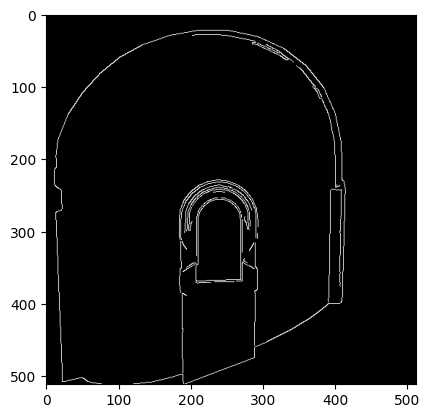

In [50]:
kiui.vis.plot_image(torch.tensor(np.array(detector(out['comp_rgb'].squeeze(0).detach().cpu() * 255)) / 255).unsqueeze(0).to(torch.float16).cuda())

In [51]:
seed = 0
grad_clip_rgb = 5
grad_suppress_type = 0

In [52]:
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [53]:
for step in tqdm(range(num_steps + 1)):
    
    guidance.update_step(epoch=step, global_step=step)
    encoding_optimizer.zero_grad()
    optimizer.zero_grad()
    if step % 50 == 0:
        dataset.update_step(epoch=step, global_step=step)
    sample_data = dataset.collate(dataset.batch_size)

    batch = {
        'elevation': sample_data['elevation'],
        'azimuth': sample_data['azimuth'],
        'camera_distances': sample_data['camera_distances']
    }
    
    with autocast(enabled=True):
        for i in range(dataset.batch_size):
            out = rasterizer(sample_data['mvp_mtx'][i:i+1].cuda(), sample_data['camera_positions'][i:i+1].cuda(), sample_data['light_positions'][i:i+1].cuda(), 1024, 1024, sample_data['c2w'][i:i+1].cuda())
            canny = torch.tensor(np.array(detector(out['comp_rgb'].squeeze(0).detach().cpu() * 255)) / 255).unsqueeze(0).to(torch.float16).cuda()
            pred_rgb = out['comp_rgb']
        if step % 50 == 0:
            j = random.randint(0, dataset.batch_size - 1)
            kiui.utils.write_image(f'./test_plot/1/{step}.png', pred_rgb)

        guidance.cfg.warm_up_rate = 1. - min(step/1000, 1.)
        
        loss = guidance(pred_rgb, canny, **batch, rgb_as_latents=False, guidance_eval=False, prompt_utils=prompt_processor(), condition_scale=0.5)
        grad = loss['loss_sds']

    # print(grad)
    scaler1.scale(grad).backward(retain_graph=True)
    scaler1.unscale_(encoding_optimizer)
    scaler1.step(encoding_optimizer)
    scaler1.update()

    scaler2.scale(grad).backward()
    scaler2.unscale_(optimizer)
    scaler2.step(optimizer)
    scaler2.update()
    if scheduler is not None:
        scheduler.step()

  0%|          | 11/3001 [00:05<23:38,  2.11it/s] 


KeyboardInterrupt: 

In [ ]:
# encoding_optimizer = torch.optim.AdamW(list(mesh.encoding.parameters()), lr=0.01, betas=(0.9, 0.99), eps=1e-15)
# optimizer = torch.optim.AdamW(list(mesh.feature_network.parameters()), lr=0.001, betas=(0.9, 0.99), eps=1e-15)

In [ ]:
sample_data = dataset.collate(4)
i = 0
out = rasterizer(sample_data['mvp_mtx'][i:i+1].cuda(), sample_data['camera_positions'][i:i+1].cuda(), sample_data['light_positions'][i:i+1].cuda(), 512, 512, sample_data['c2w'][i:i+1].cuda())
kiui.vis.plot_image(out['comp_rgb'])

In [ ]:
dataloader = RandomCameraDataModule(camera_config)

In [ ]:
dataloader.setup("test")

In [ ]:
for j, sample_data in enumerate(dataloader.test_dataloader()):
    i = 0
    out = rasterizer(sample_data['mvp_mtx'][i:i+1].cuda(), sample_data['camera_positions'][i:i+1].cuda(), sample_data['light_positions'][i:i+1].cuda(), 512, 512, sample_data['c2w'][i:i+1].cuda())
    kiui.utils.write_image(f'./output/ipiu/SDXL/test/5/image/rgb_{j:03d}.png', out['comp_rgb'])
    # kiui.utils.write_image(f'./output_plot/com2024/teddy_teddy/normal_{j:03d}.png', out['comp_normal'])

In [ ]:
from threestudio.utils.saving import SaverMixin
from threestudio.models.exporters.mesh_exporter import MeshExporter

export_config = {
        'fmt': "obj-mtl",  # in ['obj-mtl', 'obj'], TODO: fbx
        'save_name': "mesh",
        'save_normal': True,
        'save_uv': True,
        'save_texture': True,
        'texture_size': 1024,
        'texture_format': "png",
        # xatlas_chart_options: field(default_factory=dict)
        # xatlas_pack_options: field(default_factory=dict)
        'context_type': "cuda",
}

exporter = MeshExporter(export_config, mesh, material, background)

output = exporter()
save_utils = SaverMixin()
save_utils.set_save_dir("./output/ipiu/SDXL/test/5/")

for out in output:
    func_name = f"save_{out.save_type}"
    save_func = getattr(save_utils, func_name)
    save_func(f"{out.save_name}", **out.params)

In [ ]:
torch.save(mesh.encoding.state_dict(), "./output/ipiu/SDXL/test/5/encoding.pth")
torch.save(mesh.feature_network.state_dict(), "./output/ipiu/SDXL/test/5/mlp.pth")

In [ ]:
# for attn_name, attn_processor in guidance.pipe.unet.attn_processors.items():
#     # print(attn_name)
#     if "down_blocks.2" in attn_name:
#         print(attn_name)
#     # if "up" in attn_name:
#     #     attn_processor.scale = scale
#     # else:
#     #     attn_processor.scale = 0.0